In [1]:
import pickle
import os
import multiprocessing

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from scipy.stats import norm

from copy import deepcopy
import itertools
import random

from collections import OrderedDict


import torch
import torch.nn as nn


from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score



def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

seed_everything(42)


blue = '#0073B7'
yellow = '#FFD23F'
gray = '#7A7A7A'
purple = '#B05AA3'
green = '#00A651'
orange = '#F7941D'


blue_yellow = LinearSegmentedColormap.from_list(
    "blue_yellow", ["#0073B7", "#FFD23F"]
)


gray = '#C0C0C0'
purple = '#B05AA3'

gray_purple = LinearSegmentedColormap.from_list(
    "gray_purple",
    [gray , purple]
)

blue = '#00AEEF'
red = '#F15A2A'

In [2]:
from src.model import SSCNetwork
from src.utils.general import make_input, LatentSpace, get_ordered_indices, get_sample_from_num_swaps, test_network, get_cos_sim_torch
from src.utils.plotting import compare_distributions_12
from Figure_6_utils import sensory_semantic_replay
from network_parameters import network_parameters


In [3]:
os.environ["OMP_NUM_THREADS"]="1"
os.environ["MKL_NUM_THREADS"]="1"
os.environ["OPENBLAS_NUM_THREADS"]="1"
os.environ["NUMEXPR_NUM_THREADS"]="1"
os.environ["MKL_DYNAMIC"]="FALSE"
torch.set_num_threads(1)
torch.set_num_interop_threads(1)
multiprocessing.set_start_method("fork")

In [4]:
def test_network(net, input_params, sleep=False, print_rate=1):
  input, input_episodes, input_latents = make_input(**input_params)
  with torch.no_grad():
    for day in range(input_params["num_days"]):
      if day%print_rate == 0:
        print(day)
      net(input[day], debug=False)
      if sleep:
        net.sleep()
  return input, input_episodes, input_latents, net

In [5]:
#make network randomly project sensory input to obtain a wide distribution of selectivity in MTL-sensory
network_parameters["mtl_dense_sen_projection"] = True
network_parameters["mtl_dense_sen_size"] = 30
network_parameters["max_post_mtl_dense_sen"] = 1
network_parameters["max_pre_mtl_dense_sen"] = np.inf

recording_parameters = {}
recording_parameters["regions"] = ["sen", "mtl_sparse", "mtl_dense", "ctx", "mtl"]
recording_parameters["rate_activity"] = 1
recording_parameters["connections"] = []
recording_parameters["rate_connectivity"] = np.inf

num_episodes = 5
input_params = {}
input_params["num_days"] = 1
input_params["day_length"] = 5 * num_episodes
input_params["mean_duration"] = 5
input_params["fixed_duration"] = True
input_params["num_swaps"] = 2

latent_specs = {}
latent_specs["num"] = 2
latent_specs["total_sizes"] = [50, 50]
latent_specs["act_sizes"] = [10, 10]
latent_specs["dims"] = [5, 5]
latent_specs["prob_list"] = [0.5/5 if i==j else 0.5/20 for i in range(5) for j in range(5)]
input_params["latent_space"] = LatentSpace(**latent_specs)

In [6]:

def episode_recall(net, ep, num_swaps):
    num_iterations = 10
    mtl_dense_corrupted =  get_sample_from_num_swaps(ep[:net.mtl_dense_size], num_swaps)
    mtl_0 = torch.zeros((net.mtl_size))
    mtl_0[:net.mtl_dense_size] = mtl_dense_corrupted
    mtl = mtl_0.clone()
    #ctx = net.activation(F.linear(net.ctx_mtl, mtl), 'ctx')[0]
    #mtl_sparse = net.activation(F.linear(net.mtl_sparse_ctx, ctx), 'mtl_sparse')[0]
    #mtl[net.mtl_dense_size:] = mtl_sparse
    for iteration in range(num_iterations):
      mtl_hat = F.linear(net.mtl_mtl, mtl)
      mtl, _ = net.activation(mtl_hat, 'mtl')

    recall_dense = get_cos_sim_torch(mtl[:net.mtl_dense_size], ep[:net.mtl_dense_size])
    recall_sparse = get_cos_sim_torch(mtl[net.mtl_dense_size:], ep[net.mtl_dense_size:])
    recall = get_cos_sim_torch(mtl, ep)
    return mtl_0, mtl, recall_dense, recall_sparse, recall




def get_recalls(network):
    num_trials = 10
    recalls = []
    recalls_sparse = []
    recalls_dense = []
    for trial in range(num_trials):
        network.init_recordings(recording_parameters)
        network.frozen = False
        network.activity_recordings_rate = 1
        network.connectivity_recordings_rate = np.inf

        input, input_episodes, input_latents, network = test_network(
            network, input_params, sleep=False, print_rate=50
        )

        for episode in torch.stack(network.activity_recordings["mtl"], axis=0):
            mtl_0, mtl, recall_dense, recall_sparse, recall = episode_recall(network, episode, num_swaps=5)
            recalls.append(recall)
            recalls_sparse.append(recall_sparse)
            recalls_dense.append(recall_dense)

    return recalls, recalls_dense, recalls_sparse


def get_replays(network):

    def get_max_overlap(replayed, prototpyes):
        cos_sims = [get_cos_sim_torch(replayed, prototype) for prototype in prototpyes]
        max_sim = torch.max(torch.stack(cos_sims, dim=0))
        return max_sim.item()

    num_trials = 100
    num_replays = 5
    num_iterations = 10
    replays = []
    for trial in range(num_trials):
        network.init_recordings(recording_parameters)
        network.frozen = False
        network.activity_recordings_rate = 1
        network.connectivity_recordings_rate = np.inf

        input, input_episodes, input_latents, network = test_network(
            network, input_params, sleep=False, print_rate=50
        )


        for replay in range(num_replays):
            mtl = torch.randn(network.mtl_size)
            for iteration in range(num_iterations):
                mtl_hat = F.linear(network.mtl_mtl, mtl)
                mtl, _ = network.activation(mtl_hat, 'mtl')
            replays.append(get_max_overlap(mtl,torch.stack(network.activity_recordings["mtl"], axis=0)))

    return replays

In [7]:
network_intact = torch.load("checkpoints/network_5_blocked_best.pt", weights_only=False)

In [8]:
network_intact.init_recordings(recording_parameters)
network_intact.frozen = False
network_intact.activity_recordings_rate = 1
network_intact.connectivity_recordings_rate = np.inf


input, input_episodes, input_latents, network = test_network(
    network_intact, input_params, sleep=False, print_rate=50
)

0


In [9]:
mtl_dense_0 = torch.stack(network_intact.activity_recordings["mtl_dense"], axis=0)[network_intact.awake_indices][-1]
mtl_0 = torch.zeros(network_intact.mtl_size)
mtl_0[:network.mtl_dense_size] = mtl_dense_0
mtl = network.pattern_complete("mtl", mtl_0)

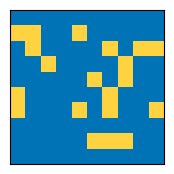

In [10]:
fig = plt.figure(figsize=(2, 2))
plt.imshow(mtl_dense_0.reshape(-1, 10), cmap=blue_yellow)
plt.xticks([])
plt.yticks([])
plt.savefig('Figures_SVG/6b1.svg', dpi=300, transparent=True)

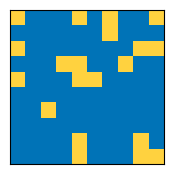

In [11]:
fig = plt.figure(figsize=(2, 2))
plt.imshow(mtl[:network.mtl_dense_size].reshape(-1, 10), cmap=blue_yellow)
plt.xticks([])
plt.yticks([])
plt.savefig('Figures_SVG/6b2.svg', dpi=300, transparent=True)

In [12]:
def test_network(net, input_params, sleep=False, print_rate=1):
  input, input_episodes, input_latents = make_input(**input_params)
  with torch.no_grad():
    for day in range(input_params["num_days"]):
      if day%print_rate == 0:
        print(day)
      net(input[day], debug=False)
      if sleep:
        net.sleep()
  return input, input_episodes, input_latents, net

In [13]:

recalls_intact = get_recalls(network_intact)
replays_intact = get_replays(network_intact)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [14]:
network_scrambled = deepcopy(network_intact)

# Generate independent permutations for each row
perms = torch.argsort(torch.rand_like(network_scrambled.mtl_sparse_ctx), dim=1)
# Apply the permutations
network_scrambled.mtl_sparse_ctx = torch.gather(network_scrambled.mtl_sparse_ctx, dim=1, index=perms)
# Freeze ctx to mtl sparse connections
network_scrambled.mtl_sparse_ctx_lmbda = 0
network_scrambled.mtl_sparse_b[:] = -1

In [15]:

recalls_scrambled = get_recalls(network_scrambled)
replays_scrambled = get_replays(network_scrambled)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


/home/aa10522/Desktop/sensory-semantic-episodes/src/utils/plotting.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=groups, y=data, inner=None, cut=0, alpha=0.9, palette=palette)


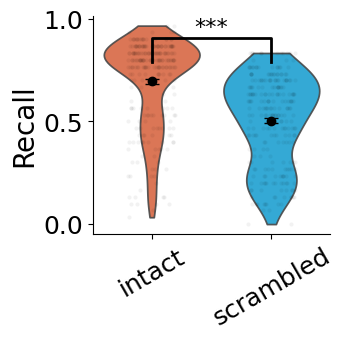

In [16]:
dist1 = ('intact', recalls_intact[0])
dist2 = ('scrambled', recalls_scrambled[0])

palette = {
    "intact": red, 
    "scrambled": blue
}

compare_distributions_12(dist1, dist2, palette)
plt.ylabel("Recall", fontsize=20)
plt.xticks(fontsize=18, rotation=30)
plt.yticks([0, 0.5, 1], fontsize=18)
plt.tight_layout()
sns.despine()
plt.savefig('Figures_SVG/6c.svg', dpi=300, transparent=True)


/home/aa10522/Desktop/sensory-semantic-episodes/src/utils/plotting.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=groups, y=data, inner=None, cut=0, alpha=0.9, palette=palette)


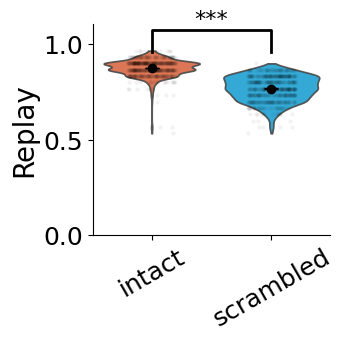

In [17]:
dist1 = ('intact', replays_intact)
dist2 = ('scrambled', replays_scrambled)

palette = {
    "intact": red,   # light blue
    "scrambled": blue
}

compare_distributions_12(dist1, dist2, palette)
plt.ylabel("Replay", fontsize=20)
plt.xticks(fontsize=18, rotation=30)
plt.yticks([0, 0.5, 1], fontsize=18)
plt.tight_layout()
sns.despine()
plt.savefig('Figures_SVG/6e.svg', dpi=300, transparent=True)

In [18]:
num_episodes = 5
input_params = {}
input_params["num_days"] = 1
input_params["day_length"] = 200
input_params["mean_duration"] = 1
input_params["fixed_duration"] = True
input_params["num_swaps"] = 2

latent_specs = {}
latent_specs["num"] = 2
latent_specs["total_sizes"] = [50, 50]
latent_specs["act_sizes"] = [10, 10]
latent_specs["dims"] = [5, 5]
latent_specs["prob_list"] = [0.5/5 if i==j else 0.5/20 for i in range(5) for j in range(5)]
input_params["latent_space"] = LatentSpace(**latent_specs)

In [19]:
input, input_episodes, input_latents, network = test_network(network, input_params, print_rate=50)

0


In [20]:
mtl_sen_episodes = torch.stack(network.activity_recordings["mtl_dense"], axis=0)[network.awake_indices][-200:]

In [21]:
mtl_semantic_episodes = torch.stack(network.activity_recordings["mtl_sparse"], axis=0)[network.awake_indices][-200:]

In [22]:
overlaps = []
overlap_latents = []

for episode_i, latent_i in zip(mtl_sen_episodes, input_latents.squeeze(0)):
    for episode_j, latent_j in zip(mtl_sen_episodes, input_latents.squeeze(0)):
        overlaps.append(get_cos_sim_torch(episode_i, episode_j))
        sim_latent = 0
        if latent_i[0] == latent_j[0]:
            sim_latent += 1
        if latent_i[1] == latent_j[1]:
            sim_latent += 1
        overlap_latents.append(sim_latent)


In [23]:
overlaps = []
overlap_latents = []

for episode_i, latent_i in zip(mtl_semantic_episodes, input_latents.squeeze(0)):
    for episode_j, latent_j in zip(mtl_semantic_episodes, input_latents.squeeze(0)):
        overlaps.append(get_cos_sim_torch(episode_i, episode_j))
        sim_latent = 0
        if latent_i[0] == latent_j[0]:
            sim_latent += 1
        if latent_i[1] == latent_j[1]:
            sim_latent += 1
        overlap_latents.append(sim_latent)


In [24]:
def get_recall(network_path, recording_parameters, input_params, latent_specs, mode, seed, get_recordings=False):
    print(f"starting simulation {mode} - {seed}")


    network = torch.load(network_path, weights_only=False)

    if mode == 'scrambled':
        # Generate independent permutations for each row
        perms = torch.argsort(torch.rand_like(network.mtl_sparse_ctx), dim=1)
        # Apply the permutations
        network.mtl_sparse_ctx = torch.gather(network.mtl_sparse_ctx, dim=1, index=perms)
        # Freeze ctx to mtl sparse connections
        network.mtl_sparse_ctx_lmbda = 0
        network.mtl_sparse_b[:] = -1

    num_episodes_range = [1, 5, 10, 15, 20, 25, 30, 40, 60, 80, 100, 200, 400, 1000]
    num_swaps_range = [2]

    len_episode_range = len(num_episodes_range)
    len_swaps_range = len(num_swaps_range)

    # Allocate trial axis (first dim)
    recall_dense = torch.zeros((len_episode_range, len_swaps_range))
    recall_sparse = torch.zeros((len_episode_range, len_swaps_range))
    recall = torch.zeros((len_episode_range, len_swaps_range))
    
    if get_recordings:
        mtl_input_recordings_all = []
        mtl_corrupted_recordings_all = []
        mtl_recall_recordings_all = []




    for num_episodes_idx, num_episodes in enumerate(num_episodes_range):

        seed_everything(seed)

        input_params = {}
        input_params["num_days"] = 1
        input_params["day_length"] = 5 * num_episodes
        input_params["mean_duration"] = 5
        input_params["fixed_duration"] = True
        input_params["num_swaps"] = 2

        latent_specs = {}
        latent_specs["num"] = 2
        latent_specs["total_sizes"] = [50, 50]
        latent_specs["act_sizes"] = [10, 10]
        latent_specs["dims"] = [5, 5]
        latent_specs["prob_list"] = [0.5/5 if i==j else 0.5/20 for i in range(5) for j in range(5)]
        #atent_specs["prob_list"] = [1/25 for i in range(5) for j in range(5)]
        input_params["latent_space"] = LatentSpace(**latent_specs)

        network.init_recordings(recording_parameters)
        network.frozen = False
        network.activity_recordings_rate = 1
        network.connectivity_recordings_rate = np.inf

        input, input_episodes, input_latents, network = test_network(
            network, input_params, sleep=False, print_rate=np.inf
        )

        for num_swap_idx, num_swap in enumerate(num_swaps_range):
            mtl_input_recordings = torch.zeros((input_params["day_length"], network.mtl_size))
            mtl_corrupted_recordings = torch.zeros((input_params["day_length"], network.mtl_size))
            mtl_recall_recordings = torch.zeros((input_params["day_length"], network.mtl_size))
            rd = torch.zeros(input_params["day_length"])
            rs = torch.zeros(input_params["day_length"])
            r = torch.zeros(input_params["day_length"])
            for episode_idx, episode in enumerate(torch.stack(network.activity_recordings["mtl"], dim=0)[1:]):
                mtl_0, mtl, rd[episode_idx], rs[episode_idx], r[episode_idx] = episode_recall(network, episode, num_swap)
                if get_recordings:
                    mtl_input_recordings[episode_idx] = episode.clone()
                    mtl_corrupted_recordings[episode_idx] = mtl_0.clone()
                    mtl_recall_recordings[episode_idx] = mtl.clone()
            recall_dense[num_episodes_idx, num_swap_idx] = rd.mean()
            recall_sparse[num_episodes_idx, num_swap_idx] = rs.mean()
            recall[num_episodes_idx, num_swap_idx] = r.mean()

        if get_recordings:
            mtl_input_recordings_all.append(mtl_input_recordings)
            mtl_corrupted_recordings_all.append(mtl_corrupted_recordings)
            mtl_recall_recordings_all.append(mtl_recall_recordings)

    if get_recordings:
        return mtl_input_recordings_all, mtl_corrupted_recordings_all, mtl_recall_recordings_all, recall_dense, recall_sparse, recall

    return recall_dense, recall_sparse, recall

In [25]:
network_path = "checkpoints/network_5_blocked_best.pt"
mtl_input_recordings_all, mtl_corrupted_recordings_all, mtl_recall_recordings_all, recall_dense, recall_sparse, recall = get_recall(network_path,recording_parameters, input_params, latent_specs, mode='intact', seed=0, get_recordings=True)

starting simulation intact - 0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [26]:
network_intact = torch.load("checkpoints/network_5_blocked_best.pt", weights_only=False)

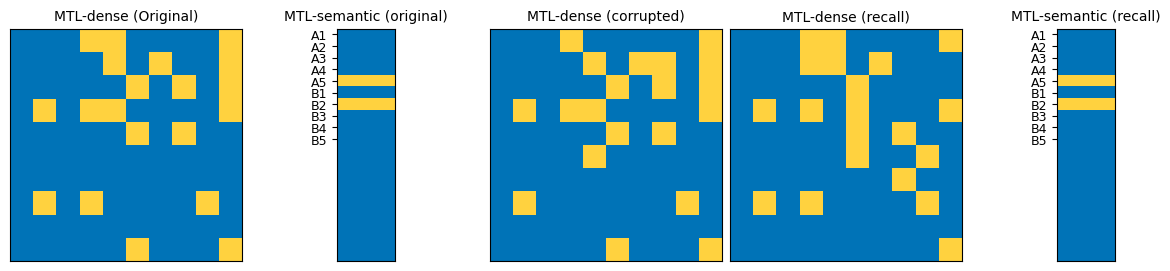

In [27]:
num_episodes_index = 0
pattern_index = 0

# --- Helpers ---
def add_group_labels(ax, NA=5, NB=5, N_rows=10):
    M = N_rows // (NA + NB)
    labels_A = [f"A{i+1}" for i in range(NA)]
    labels_B = [f"B{i+1}" for i in range(NB)]
    labels = labels_A + labels_B
    positions = [M * i for i in range(NA + NB)]
    ax.set_yticks(positions)
    ax.set_yticklabels(labels, fontsize=9)

def to_matrix_torch(vec, ncols: int):
    assert isinstance(vec, torch.Tensor)
    total = vec.numel()
    return vec.reshape(total // ncols, ncols)


ne = num_episodes_index
pi = pattern_index
D = network_intact.mtl_dense_size
ord_idx = network_intact.ordered_indices_mtl_sparse 

dense_input   = mtl_input_recordings_all[ne][pi][:D]
sparse_input  = mtl_input_recordings_all[ne][pi][D:][ord_idx]
dense_corrupt = mtl_corrupted_recordings_all[ne][pi][:D]
sparse_recall = mtl_recall_recordings_all[ne][pi][D:][ord_idx]
dense_recall  = mtl_recall_recordings_all[ne][pi][:D]


fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 2.6), constrained_layout=True)

# Panel 1: Input Dense
mat = to_matrix_torch(dense_input, ncols=10)
im0 = axs[0].imshow(mat, cmap=blue_yellow)
axs[0].set_title("MTL-dense (Original)", fontsize=10)
axs[0].set_xticks([]); axs[0].set_yticks([])

# Panel 2: Input Sparse
mat = to_matrix_torch(sparse_input, ncols=5)
im1 = axs[1].imshow(mat, cmap=blue_yellow)
axs[1].set_title("MTL-semantic (original)", fontsize=10)
axs[1].set_xticks([])
add_group_labels(axs[1], NA=5, NB=5, N_rows=int(mat.shape[0]/2))

# Panel 3: Corrupted Dense
mat = to_matrix_torch(dense_corrupt, ncols=10)
im2 = axs[2].imshow(mat, cmap=blue_yellow)
axs[2].set_title("MTL-dense (corrupted)", fontsize=10)
axs[2].set_xticks([]); axs[2].set_yticks([])


# Panel 5: Recall Dense
mat = to_matrix_torch(dense_recall, ncols=10)
im4 = axs[3].imshow(mat, cmap=blue_yellow)
axs[3].set_title("MTL-dense (recall)", fontsize=10)
axs[3].set_xticks([]); axs[3].set_yticks([])

# Panel 4: Recall Sparse
mat = to_matrix_torch(sparse_recall, ncols=5)
im3 = axs[4].imshow(mat, cmap=blue_yellow)
axs[4].set_title("MTL-semantic (recall)", fontsize=10)
axs[4].set_xticks([])
add_group_labels(axs[4], NA=5, NB=5, N_rows=int(mat.shape[0]/2))

fig.savefig("Figures_SVG/6_supp_1.svg", dpi=300, transparent=True)

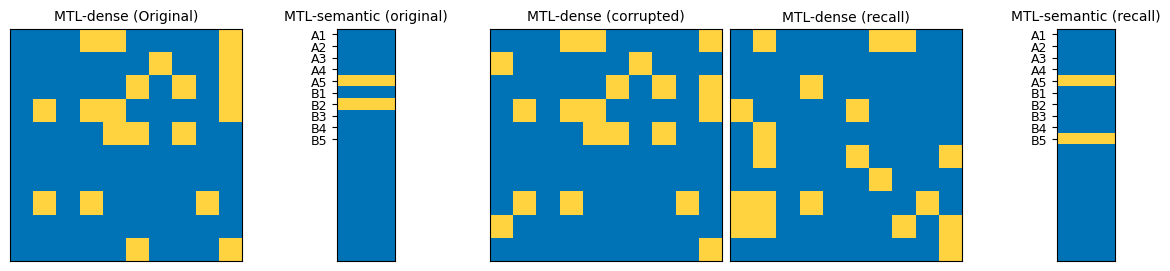

In [28]:
num_episodes_index = -1
pattern_index = 0

# --- Helpers ---
def add_group_labels(ax, NA=5, NB=5, N_rows=10):
    M = N_rows // (NA + NB)
    labels_A = [f"A{i+1}" for i in range(NA)]
    labels_B = [f"B{i+1}" for i in range(NB)]
    labels = labels_A + labels_B
    positions = [M * i for i in range(NA + NB)]
    ax.set_yticks(positions)
    ax.set_yticklabels(labels, fontsize=9)

def to_matrix_torch(vec, ncols: int):
    assert isinstance(vec, torch.Tensor)
    total = vec.numel()
    return vec.reshape(total // ncols, ncols)


ne = num_episodes_index
pi = pattern_index
D = network_intact.mtl_dense_size
ord_idx = network_intact.ordered_indices_mtl_sparse 

dense_input   = mtl_input_recordings_all[ne][pi][:D]
sparse_input  = mtl_input_recordings_all[ne][pi][D:][ord_idx]
dense_corrupt = mtl_corrupted_recordings_all[ne][pi][:D]
sparse_recall = mtl_recall_recordings_all[ne][pi][D:][ord_idx]
dense_recall  = mtl_recall_recordings_all[ne][pi][:D]


fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 2.6), constrained_layout=True)

# Panel 1: Input Dense
mat = to_matrix_torch(dense_input, ncols=10)
im0 = axs[0].imshow(mat, cmap=blue_yellow)
axs[0].set_title("MTL-dense (Original)", fontsize=10)
axs[0].set_xticks([]); axs[0].set_yticks([])

# Panel 2: Input Sparse
mat = to_matrix_torch(sparse_input, ncols=5)
im1 = axs[1].imshow(mat, cmap=blue_yellow)
axs[1].set_title("MTL-semantic (original)", fontsize=10)
axs[1].set_xticks([])
add_group_labels(axs[1], NA=5, NB=5, N_rows=int(mat.shape[0]/2))

# Panel 3: Corrupted Dense
mat = to_matrix_torch(dense_corrupt, ncols=10)
im2 = axs[2].imshow(mat, cmap=blue_yellow)
axs[2].set_title("MTL-dense (corrupted)", fontsize=10)
axs[2].set_xticks([]); axs[2].set_yticks([])


# Panel 5: Recall Dense
mat = to_matrix_torch(dense_recall, ncols=10)
im4 = axs[3].imshow(mat, cmap=blue_yellow)
axs[3].set_title("MTL-dense (recall)", fontsize=10)
axs[3].set_xticks([]); axs[3].set_yticks([])

# Panel 4: Recall Sparse
mat = to_matrix_torch(sparse_recall, ncols=5)
im3 = axs[4].imshow(mat, cmap=blue_yellow)
axs[4].set_title("MTL-semantic (recall)", fontsize=10)
axs[4].set_xticks([])
add_group_labels(axs[4], NA=5, NB=5, N_rows=int(mat.shape[0]/2))

fig.savefig("Figures_SVG/6_supp_2.svg", dpi=300, transparent=True)

In [29]:

num_cpu = 100
modes = ["intact", "scrambled"]
num_seeds = 50
seeds = np.arange(num_seeds)
seeds = [int(s) for s in np.asarray(seeds).ravel().tolist()]

In [30]:
network_path = "checkpoints/network_5_blocked_best.pt"
experiment_params = [(network_path,recording_parameters, input_params, latent_specs, mode, seed) for mode in modes for seed in seeds]
pool = multiprocessing.Pool(processes=num_cpu)

results_list = pool.starmap(get_recall, experiment_params)

starting simulation intact - 0starting simulation intact - 1

starting simulation intact - 2
starting simulation intact - 3
starting simulation intact - 4starting simulation intact - 5starting simulation intact - 6


starting simulation intact - 7
starting simulation intact - 10starting simulation intact - 11

starting simulation intact - 12
starting simulation intact - 13
starting simulation intact - 14
starting simulation intact - 15starting simulation intact - 16

starting simulation intact - 17starting simulation intact - 19starting simulation intact - 18

starting simulation intact - 20starting simulation intact - 21
starting simulation intact - 24
starting simulation intact - 23
starting simulation intact - 22

starting simulation intact - 25
starting simulation intact - 28
starting simulation intact - 27starting simulation intact - 26

starting simulation intact - 29
starting simulation intact - 8starting simulation intact - 30
starting simulation intact - 32starting simulation 

In [31]:
def save_results(results_list, filename):


    results = {}
    results["recall_dense"] = []
    results["recall_sparse"] = []
    results["recall"] = []


    for recall_dense, recall_sparse, recall in results_list:


        results["recall_dense"].append(recall_dense)
        results["recall_sparse"].append(recall_sparse)
        results["recall"].append(recall)

    with open('Data/{}'.format(filename), 'wb') as handle:
        pickle.dump(dict(results), handle, protocol=pickle.HIGHEST_PROTOCOL)


save_results(results_list, filename='fig_6_network_capacity.pickle')

In [32]:
with open('Data/{}'.format('fig_6_network_capacity.pickle'), 'rb') as handle:
    results = pickle.load(handle)

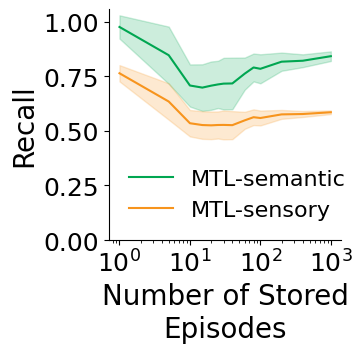

In [33]:
recall_sparse_intact = torch.stack(results["recall_sparse"][:num_seeds])
recall_dense_intact = torch.stack(results["recall_dense"][:num_seeds])

x = [1, 5, 10, 15, 20, 25, 30, 40, 60, 80, 100, 200, 400, 1000]

# medias y stds
sparse_mean = recall_sparse_intact.mean(axis=0).squeeze(1)
sparse_std  = recall_sparse_intact.std(axis=0).squeeze(1)

dense_mean  = recall_dense_intact.mean(axis=0).squeeze(1)
dense_std   = recall_dense_intact.std(axis=0).squeeze(1)

fig = plt.figure(figsize=(3, 3))

# sparse
plt.plot(x, sparse_mean, label="MTL-semantic", color=green)
plt.fill_between(
    x,
    sparse_mean - sparse_std,
    sparse_mean + sparse_std,
    color=green,
    alpha=0.2
)

# dense
plt.plot(x, dense_mean, label="MTL-sensory", color=orange)
plt.fill_between(
    x,
    dense_mean - dense_std,
    dense_mean + dense_std,
    color=orange,
    alpha=0.2
)

plt.legend(frameon=False, fontsize=16)
plt.xscale("log")
plt.yticks([0, 0.25, 0.5, 0.75, 1], fontsize=18)
plt.xticks(fontsize=18)
sns.despine()
plt.xlabel("Number of Stored\nEpisodes", fontsize=20)
plt.ylabel("Recall", fontsize=20)

plt.savefig('Figures_SVG/6d.svg', dpi=300, transparent=True)

<Figure size 300x300 with 0 Axes>

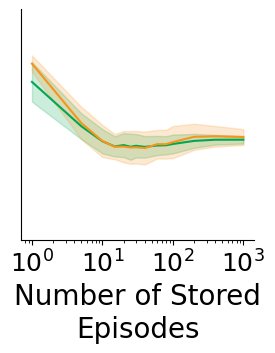

In [34]:
fig = plt.figure(figsize=((3, 3)))
recall_sparse_scrambled = torch.stack(results["recall_sparse"][num_seeds:])
recall_dense_scrambled = torch.stack(results["recall_dense"][num_seeds:])

x = [1, 5, 10, 15, 20, 25, 30, 40, 60, 80, 100, 200, 400, 1000]

# medias y stds
sparse_mean = recall_sparse_scrambled.mean(axis=0).squeeze(1)
sparse_std  = recall_sparse_scrambled.std(axis=0).squeeze(1)

dense_mean  = recall_dense_scrambled.mean(axis=0).squeeze(1)
dense_std   = recall_dense_scrambled.std(axis=0).squeeze(1)

fig = plt.figure(figsize=(3, 3))

# sparse
plt.plot(x, sparse_mean, label="MTL-semantic", color=green)
plt.fill_between(
    x,
    sparse_mean - sparse_std,
    sparse_mean + sparse_std,
    color=green,
    alpha=0.2
)

# dense
plt.plot(x, dense_mean, label="MTL-sensory", color=orange)
plt.fill_between(
    x,
    dense_mean - dense_std,
    dense_mean + dense_std,
    color=orange,
    alpha=0.2
)


plt.xscale("log")
plt.yticks([])
plt.ylim([0, 1])


plt.xticks(fontsize=18)
sns.despine()
plt.xlabel("Number of Stored\nEpisodes", fontsize=20)
#plt.ylabel("Recall", fontsize=20)

plt.savefig('Figures_SVG/6d2.svg', dpi=300, transparent=True)

In [35]:
network_intact = torch.load("checkpoints/network_5_blocked_median.pt", weights_only=False)

In [36]:
recalls_intact = get_recalls(network_intact)
replays_intact = get_replays(network_intact)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [37]:
network_scrambled = deepcopy(network_intact)

# Generate independent permutations for each row
perms = torch.argsort(torch.rand_like(network_scrambled.mtl_sparse_ctx), dim=1)
# Apply the permutations
network_scrambled.mtl_sparse_ctx = torch.gather(network_scrambled.mtl_sparse_ctx, dim=1, index=perms)
# Freeze ctx to mtl sparse connections
network_scrambled.mtl_sparse_ctx_lmbda = 0
network_scrambled.mtl_sparse_b[:] = -1

In [38]:
recalls_scrambled = get_recalls(network_scrambled)
replays_scrambled = get_replays(network_scrambled)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


/home/aa10522/Desktop/sensory-semantic-episodes/src/utils/plotting.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=groups, y=data, inner=None, cut=0, alpha=0.9, palette=palette)


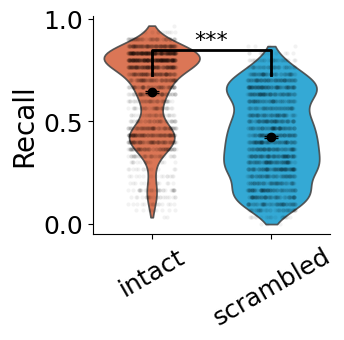

In [39]:
dist1 = ('intact', recalls_intact[0])
dist2 = ('scrambled', recalls_scrambled[0])

palette = {
    "intact": red, 
    "scrambled": blue
}

compare_distributions_12(dist1, dist2, palette)
plt.ylabel("Recall", fontsize=20)
plt.xticks(fontsize=18, rotation=30)
plt.yticks([0, 0.5, 1], fontsize=18)
plt.tight_layout()
sns.despine()
plt.savefig('Figures_SVG/6c_supp.svg', dpi=300, transparent=True)


/home/aa10522/Desktop/sensory-semantic-episodes/src/utils/plotting.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=groups, y=data, inner=None, cut=0, alpha=0.9, palette=palette)


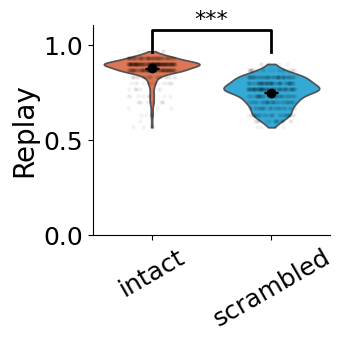

In [40]:
dist1 = ('intact', replays_intact)
dist2 = ('scrambled', replays_scrambled)

palette = {
    "intact": red,   # light blue
    "scrambled": blue
}

compare_distributions_12(dist1, dist2, palette)
plt.ylabel("Replay", fontsize=20)
plt.xticks(fontsize=18, rotation=30)
plt.yticks([0, 0.5, 1], fontsize=18)
plt.tight_layout()
sns.despine()
plt.savefig('Figures_SVG/6e_supp.svg', dpi=300, transparent=True)

In [41]:
network_path = "checkpoints/network_5_blocked_median.pt"
experiment_params = [(network_path,recording_parameters, input_params, latent_specs, mode, seed) for mode in modes for seed in seeds]
pool = multiprocessing.Pool(processes=num_cpu)

results_list = pool.starmap(get_recall, experiment_params)

starting simulation intact - 0
starting simulation intact - 1
starting simulation intact - 2
starting simulation intact - 3
starting simulation intact - 4starting simulation intact - 5

starting simulation intact - 6
starting simulation intact - 7starting simulation intact - 8starting simulation intact - 9starting simulation intact - 10


starting simulation intact - 12
starting simulation intact - 11starting simulation intact - 13
starting simulation intact - 14

starting simulation intact - 15
starting simulation intact - 16
starting simulation intact - 17
starting simulation intact - 19starting simulation intact - 20starting simulation intact - 18starting simulation intact - 21



starting simulation intact - 22

starting simulation intact - 23starting simulation intact - 24

starting simulation intact - 25starting simulation intact - 29starting simulation intact - 28

starting simulation intact - 26starting simulation intact - 27

starting simulation intact - 32starting simulation 

In [42]:
def save_results(results_list, filename):


    results = {}
    results["recall_dense"] = []
    results["recall_sparse"] = []
    results["recall"] = []


    for recall_dense, recall_sparse, recall in results_list:


        results["recall_dense"].append(recall_dense)
        results["recall_sparse"].append(recall_sparse)
        results["recall"].append(recall)

    with open('Data/{}'.format(filename), 'wb') as handle:
        pickle.dump(dict(results), handle, protocol=pickle.HIGHEST_PROTOCOL)


save_results(results_list, filename='fig_6_network_capacity_supp.pickle')

In [43]:
with open('Data/{}'.format('fig_6_network_capacity_supp.pickle'), 'rb') as handle:
    results = pickle.load(handle)

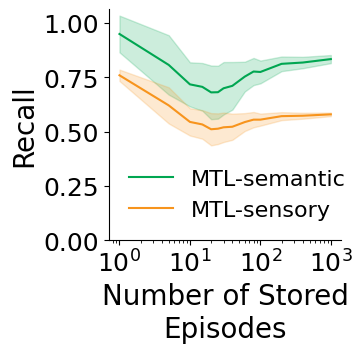

In [44]:
recall_sparse_intact = torch.stack(results["recall_sparse"][:num_seeds])
recall_dense_intact = torch.stack(results["recall_dense"][:num_seeds])

x = [1, 5, 10, 15, 20, 25, 30, 40, 60, 80, 100, 200, 400, 1000]

# medias y stds
sparse_mean = recall_sparse_intact.mean(axis=0).squeeze(1)
sparse_std  = recall_sparse_intact.std(axis=0).squeeze(1)

dense_mean  = recall_dense_intact.mean(axis=0).squeeze(1)
dense_std   = recall_dense_intact.std(axis=0).squeeze(1)

fig = plt.figure(figsize=(3, 3))

# sparse
plt.plot(x, sparse_mean, label="MTL-semantic", color=green)
plt.fill_between(
    x,
    sparse_mean - sparse_std,
    sparse_mean + sparse_std,
    color=green,
    alpha=0.2
)

# dense
plt.plot(x, dense_mean, label="MTL-sensory", color=orange)
plt.fill_between(
    x,
    dense_mean - dense_std,
    dense_mean + dense_std,
    color=orange,
    alpha=0.2
)

plt.legend(frameon=False, fontsize=16)
plt.xscale("log")
plt.yticks([0, 0.25, 0.5, 0.75, 1], fontsize=18)
plt.xticks(fontsize=18)
sns.despine()
plt.xlabel("Number of Stored\nEpisodes", fontsize=20)
plt.ylabel("Recall", fontsize=20)

plt.savefig('Figures_SVG/6d_supp.svg', dpi=300, transparent=True)

<Figure size 300x300 with 0 Axes>

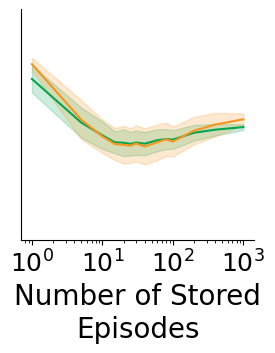

In [45]:
fig = plt.figure(figsize=((3, 3)))
recall_sparse_scrambled = torch.stack(results["recall_sparse"][num_seeds:])
recall_dense_scrambled = torch.stack(results["recall_dense"][num_seeds:])

x = [1, 5, 10, 15, 20, 25, 30, 40, 60, 80, 100, 200, 400, 1000]

# medias y stds
sparse_mean = recall_sparse_scrambled.mean(axis=0).squeeze(1)
sparse_std  = recall_sparse_scrambled.std(axis=0).squeeze(1)

dense_mean  = recall_dense_scrambled.mean(axis=0).squeeze(1)
dense_std   = recall_dense_scrambled.std(axis=0).squeeze(1)

fig = plt.figure(figsize=(3, 3))

# sparse
plt.plot(x, sparse_mean, label="MTL-semantic", color=green)
plt.fill_between(
    x,
    sparse_mean - sparse_std,
    sparse_mean + sparse_std,
    color=green,
    alpha=0.2
)

# dense
plt.plot(x, dense_mean, label="MTL-sensory", color=orange)
plt.fill_between(
    x,
    dense_mean - dense_std,
    dense_mean + dense_std,
    color=orange,
    alpha=0.2
)


plt.xscale("log")
plt.yticks([])
plt.ylim([0, 1])


plt.xticks(fontsize=18)
sns.despine()
plt.xlabel("Number of Stored\nEpisodes", fontsize=20)
#plt.ylabel("Recall", fontsize=20)

plt.savefig('Figures_SVG/6d2_supp.svg', dpi=300, transparent=True)

In [46]:


network = torch.load("checkpoints/network_5_blocked_median.pt", weights_only=False)
num_episodes = 1

seed_everything(0)

input_params = {}
input_params["num_days"] = 1
input_params["day_length"] = 5 * num_episodes
input_params["mean_duration"] = 5
input_params["fixed_duration"] = True
input_params["num_swaps"] = 2

latent_specs = {}
latent_specs["num"] = 2
latent_specs["total_sizes"] = [50, 50]
latent_specs["act_sizes"] = [10, 10]
latent_specs["dims"] = [5, 5]
latent_specs["prob_list"] = [0.5/5 if i==j else 0.5/20 for i in range(5) for j in range(5)]
input_params["latent_space"] = LatentSpace(**latent_specs)

network.init_recordings(recording_parameters)
network.frozen = False
network.activity_recordings_rate = 1
network.connectivity_recordings_rate = np.inf

input, input_episodes, input_latents, network = test_network(
    network, input_params, sleep=False, print_rate=np.inf
)


0


In [47]:
num_cpu = 100
num_seeds = 50
seeds = np.arange(num_seeds)
seeds = [int(s) for s in np.asarray(seeds).ravel().tolist()]

In [48]:
experiment_params = [(network_parameters, recording_parameters, input_params, latent_specs, seed) for seed in seeds]
pool = multiprocessing.Pool(processes=num_cpu)

results_list = pool.starmap(sensory_semantic_replay, experiment_params)

starting simulation - 0
starting simulation - 1
starting simulation - 2
starting simulation - 3starting simulation - 4

starting simulation - 5
starting simulation - 6
starting simulation - 8starting simulation - 7

starting simulation - 9starting simulation - 10

starting simulation - 11starting simulation - 12starting simulation - 13


starting simulation - 14starting simulation - 15

starting simulation - 16starting simulation - 17
starting simulation - 18

starting simulation - 20starting simulation - 19starting simulation - 22starting simulation - 21starting simulation - 23

starting simulation - 24
starting simulation - 25
starting simulation - 27
starting simulation - 26
starting simulation - 28
starting simulation - 29starting simulation - 30
starting simulation - 32



starting simulation - 33
starting simulation - 31starting simulation - 34
starting simulation - 35
starting simulation - 37
starting simulation - 36
starting simulation - 38starting simulation - 40starting simul

In [49]:
def save_results(results_list, filename):


    results = {}
    results["selectivity_mtl_sparse"] = []
    results["accuracy_mtl_sparse_1"] = []
    results["accuracy_mtl_sparse_2"] = []


    for selectivity_mtl_sparse, accuracy_1, accuracy_2 in results_list:


        results["selectivity_mtl_sparse"].append(selectivity_mtl_sparse)
        results["accuracy_mtl_sparse_1"].append(accuracy_1)
        results["accuracy_mtl_sparse_2"].append(accuracy_2)

    with open('Data/{}'.format(filename), 'wb') as handle:
        pickle.dump(dict(results), handle, protocol=pickle.HIGHEST_PROTOCOL)


save_results(results_list, filename='fig_6_sensory_semantic.pickle')

In [50]:
with open('Data/{}'.format('fig_6_sensory_semantic.pickle'), 'rb') as handle:
    results = pickle.load(handle)

/home/aa10522/Desktop/sensory-semantic-episodes/src/utils/plotting.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=groups, y=data, inner=None, cut=0, alpha=0.9, palette=palette)


<Figure size 350x550 with 0 Axes>

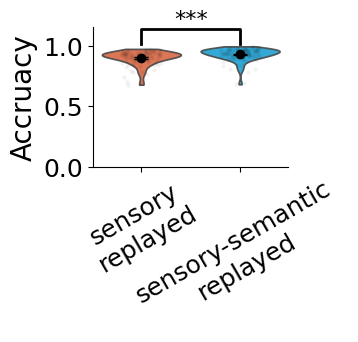

In [51]:

plt.figure(figsize=(3.5, 5.5))

# Flatten arrays
acc_pre_c = np.array(results["accuracy_mtl_sparse_1"]).flatten()
acc_post_c = np.array(results["accuracy_mtl_sparse_2"]).flatten()


dist1 = ('sensory\nreplayed', acc_pre_c)
dist2 = ('sensory-semantic\nreplayed', acc_post_c)

palette = {
    "sensory\nreplayed": red,   # light blue
    "sensory-semantic\nreplayed": blue
}

compare_distributions_12(dist1, dist2, palette)
plt.ylabel("Accruacy", fontsize=20)
plt.xticks(fontsize=18, rotation=30)
plt.yticks([0, 0.5, 1], fontsize=18)
plt.tight_layout()
sns.despine()



plt.savefig('Figures_SVG/6f.svg', dpi=300, transparent=True)

In [52]:
median_seed = np.argsort(np.array(results["accuracy_mtl_sparse_2"]).mean(axis=1))[num_seeds//2]
best_seed = np.argsort(np.array(results["accuracy_mtl_sparse_2"]).mean(axis=1))[-1]

In [53]:
network, input, input_latents, input_episodes, ordered_indices_ctx, ordered_indices_mtl_dense, ordered_indices_mtl_sparse, selectivity_ctx, selectivity_mtl_dense, selectivity_mtl_sparse, accuracy = sensory_semantic_replay(network_parameters, recording_parameters, input_params, latent_specs, seed=int(best_seed), get_network=True)
network.selectivity_ctx = selectivity_ctx
network.ordered_indices_ctx = ordered_indices_ctx
network.ordered_indices_mtl_dense = ordered_indices_mtl_dense
network.ordered_indices_mtl_sparse = ordered_indices_mtl_sparse

torch.save(network, "checkpoints/network_6_best.pt")

starting simulation - 46


0
0
0
0
0
0
0
0
0
0
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
0
50
0
50
100
150
200
250
300
350
400
450
0
50


In [54]:
network, input, input_latents, input_episodes, ordered_indices_ctx, ordered_indices_mtl_dense, ordered_indices_mtl_sparse, selectivity_ctx, selectivity_mtl_dense, selectivity_mtl_sparse, accuracy = sensory_semantic_replay(network_parameters, recording_parameters, input_params, latent_specs, seed=int(median_seed), get_network=True)
network.selectivity_ctx = selectivity_ctx
network.ordered_indices_ctx = ordered_indices_ctx
network.ordered_indices_mtl_dense = ordered_indices_mtl_dense
network.ordered_indices_mtl_sparse = ordered_indices_mtl_sparse

torch.save(network, "checkpoints/network_6_median.pt")

starting simulation - 31
0
0
0
0
0
0
0
0
0
0
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
0
50
0
50
100
150
200
250
300
350
400
450
0
50


In [55]:

#network_median = torch.load("checkpoints/network_6_median.pt", weights_only=False)
network = torch.load("checkpoints/network_6_best.pt", weights_only=False)

In [56]:
plt.hist(network_median.selectivity_ctx[network_median.ordered_indices_ctx[:100]].max(axis=1)[0])

NameError: name 'network_median' is not defined

False

In [ ]:
def get_recall(network_path, recording_parameters, input_params, latent_specs, mode, seed):
    print(f"starting simulation {mode} - {seed}")


    network = torch.load(network_path, weights_only=False)

    if mode == 'scrambled':
        # Generate independent permutations for each row
        perms = torch.argsort(torch.rand_like(network.mtl_sparse_ctx), dim=1)
        # Apply the permutations
        network.mtl_sparse_ctx = torch.gather(network.mtl_sparse_ctx, dim=1, index=perms)
        # Freeze ctx to mtl sparse connections
        network.mtl_sparse_ctx_lmbda = 0
        network.mtl_sparse_b[:] = -1

    num_episodes_range = [1, 5, 10, 15, 20, 25, 30, 40, 60, 80, 100, 200, 400, 1000]
    num_swaps_range = [5]

    len_episode_range = len(num_episodes_range)
    len_swaps_range = len(num_swaps_range)

    # Allocate trial axis (first dim)
    recall_dense = torch.zeros((len_episode_range, len_swaps_range))
    recall_sparse = torch.zeros((len_episode_range, len_swaps_range))
    recall = torch.zeros((len_episode_range, len_swaps_range))
    recall_only_dense = torch.zeros((len_episode_range, len_swaps_range))


    for num_episodes_idx, num_episodes in enumerate(num_episodes_range):

        seed_everything(seed)

        input_params = {}
        input_params["num_days"] = 1
        input_params["day_length"] = 5 * num_episodes
        input_params["mean_duration"] = 5
        input_params["fixed_duration"] = True
        input_params["num_swaps"] = 2

        latent_specs = {}
        latent_specs["num"] = 2
        latent_specs["total_sizes"] = [50, 50]
        latent_specs["act_sizes"] = [10, 10]
        latent_specs["dims"] = [5, 5]
        #latent_specs["prob_list"] = [0.5/5 if i==j else 0.5/20 for i in range(5) for j in range(5)]
        latent_specs["prob_list"] = [1/25 for i in range(5) for j in range(5)]
        input_params["latent_space"] = LatentSpace(**latent_specs)

        network.init_recordings(recording_parameters)
        network.frozen = False
        network.activity_recordings_rate = 1
        network.connectivity_recordings_rate = np.inf

        input, input_episodes, input_latents, network = test_network(
            network, input_params, sleep=False, print_rate=np.inf
        )

        for num_swap_idx, num_swap in enumerate(num_swaps_range):
            rd = torch.zeros(input_params["day_length"])
            rs = torch.zeros(input_params["day_length"])
            r = torch.zeros(input_params["day_length"])
            for episode_idx, episode in enumerate(torch.stack(network.activity_recordings["mtl"], dim=0)[1:]):
                _, _, rd[episode_idx], rs[episode_idx], r[episode_idx] = episode_recall(network, episode, num_swap)
            recall_dense[num_episodes_idx, num_swap_idx] = rd.mean()
            recall_sparse[num_episodes_idx, num_swap_idx] = rs.mean()
            recall[num_episodes_idx, num_swap_idx] = r.mean()

In [ ]:

def episode_recall(net, ep, num_swaps):
    num_iterations = 10
    mtl_dense_corrupted =  get_sample_from_num_swaps(ep[:net.mtl_dense_size], num_swaps)
    mtl_0 = torch.zeros((net.mtl_size))
    mtl_0[:net.mtl_dense_size] = mtl_dense_corrupted
    mtl = mtl_0.clone()
    for iteration in range(num_iterations):
      mtl_hat = F.linear(net.mtl_mtl, mtl)
      mtl, _ = net.activation(mtl_hat, 'mtl')

    recall_dense = get_cos_sim_torch(mtl[:net.mtl_dense_size], ep[:net.mtl_dense_size])
    recall_sparse = get_cos_sim_torch(mtl[net.mtl_dense_size:], ep[net.mtl_dense_size:])
    recall = get_cos_sim_torch(mtl, ep)
    return mtl_0, mtl, recall_dense, recall_sparse, recall